# Exploratory analysis of BNN crypto market data
## What is the evolution of a crypto pair?
In this Notebook, we shall investigate the evolution of trades for a given pair. The ultimate goal of this notebook is to gain insight into what strategy is best to use when predicting crypto prices.

BNN market data is accessible through their API. In particular, the klines endpoint allows us to access summarized market data in intervals of 1 minute up to 1 month. For this notebook, kline data in an interval of 15 minutes was used. Each 15-minute kline is uniquely identified by the following features:
- Timestamp: a 13-digit number (milliseconds) representing the opening time of a 15-minute interval
- Open, high, low, close: real numbers representing respective OHLC prices in the 15-minute interval
- Volume: the volume of the base asset that was traded
- Quote volumne: the volume of the quote asset that was traded
- Number of trades: in the 15 minute interval

These were downloaded for all 262 pairs currently traded in the Binance Spot market. We will first construct a dataframe containing info for all pairs.

In [1]:
import pandas as pd
from seaborn import heatmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
from multiprocessing import Pool
from functools import partial
from workers import csv_to_df
import os

data_folder = "../../bnndata"
features = ["ts", "open", "high", "low", "close", "volume", "quote_volume", "number_of_trades", "pair"]
bnn_data = pd.DataFrame(columns=features)
csv_list = os.listdir(data_folder)

results = process_map(csv_to_df, csv_list[120:240], max_workers=5)
bnn_data = pd.concat(results)

print(bnn_data.head())

  0%|          | 0/120 [00:00<?, ?it/s]

              ts      open      high       low     close  volume  \
0  1617933600000  0.000292  0.000293  0.000291  0.000292   80.00   
1  1617934500000  0.000292  0.000294  0.000291  0.000292  593.64   
2  1617935400000  0.000292  0.000293  0.000291  0.000292  461.37   
3  1617936300000  0.000292  0.000293  0.000291  0.000292  993.78   
4  1617937200000  0.000292  0.000293  0.000292  0.000292  525.95   

   quote_volume  number_of_trades    pair  
0      0.023345                26  ORNBTC  
1      0.173784                41  ORNBTC  
2      0.134383                40  ORNBTC  
3      0.289817                32  ORNBTC  
4      0.153644                34  ORNBTC  


### Normalizing the data
In order to homogenize data from all coins, we will normalize them by dividing every A by each pair's B:
- price, max price
- volume, max volume
- quote volume, max quote volume
- number of trades, max number of trades

Additionally, we will order each dataframe by its timestamp, so that we can compute a "relative age" variable.

In [2]:
dfs = []
pd.options.mode.chained_assignment = None
from workers import normalize_df

print("Grouping pairs")
for pair in tqdm(bnn_data.pair.unique()):
    pair_df = bnn_data[bnn_data.pair == pair]
    pair_df = pair_df.sort_values(by="ts", ascending=True).reset_index(drop=True)
    pair_df["rel_age"] = pair_df.index
    dfs.append(pair_df)

print("Running normalization")
results = process_map(normalize_df, dfs, max_workers=5)
bnn_data = pd.concat(results)

print(bnn_data.head())

Grouping pairs


  0%|          | 0/120 [00:00<?, ?it/s]

Running normalization


  0%|          | 0/120 [00:00<?, ?it/s]

              ts      open      high       low     close    volume  \
0  1601445600000  0.435666  0.735379  0.435666  0.583701  1.000000   
1  1601446500000  0.583701  0.584851  0.542474  0.555321  0.223720   
2  1601447400000  0.557047  0.566251  0.504123  0.521189  0.224100   
3  1601448300000  0.521189  0.521189  0.490892  0.498945  0.151463   
4  1601449200000  0.500288  0.543432  0.499712  0.536529  0.147247   

   quote_volume  number_of_trades  rel_age  
0      1.000000          1.000000        0  
1      0.214143          0.212151        1  
2      0.200516          0.171451        2  
3      0.129708          0.141958        3  
4      0.131716          0.126032        4  


### Augmenting the dataset
We will now compute four more features for the datasets:
- Average price: the average of the OHLC prices for each 15-min kline
- Spread: H - L
- Change: O - C
- Change percent: change divided by the average price

In [3]:
bnn_data["avg_price"] = (bnn_data.high + bnn_data.low + bnn_data.open + bnn_data.close) / 4
bnn_data["spread"] = bnn_data.high - bnn_data.low
bnn_data["change"] = bnn_data.open - bnn_data.close
bnn_data["change_pct"] = (bnn_data.change / bnn_data.avg_price) * 100
print(bnn_data.head())

              ts      open      high       low     close    volume  \
0  1601445600000  0.435666  0.735379  0.435666  0.583701  1.000000   
1  1601446500000  0.583701  0.584851  0.542474  0.555321  0.223720   
2  1601447400000  0.557047  0.566251  0.504123  0.521189  0.224100   
3  1601448300000  0.521189  0.521189  0.490892  0.498945  0.151463   
4  1601449200000  0.500288  0.543432  0.499712  0.536529  0.147247   

   quote_volume  number_of_trades  rel_age  avg_price    spread    change  \
0      1.000000          1.000000        0   0.547603  0.299712 -0.148035   
1      0.214143          0.212151        1   0.566587  0.042378  0.028380   
2      0.200516          0.171451        2   0.537152  0.062128  0.035858   
3      0.129708          0.141958        3   0.508054  0.030297  0.022244   
4      0.131716          0.126032        4   0.519990  0.043720 -0.036242   

   change_pct  
0  -27.033179  
1    5.008884  
2    6.675591  
3    4.378185  
4   -6.969669  


We will now group the data by age tier, and calculate the averages for avg_price, spread, change and change percentage.

In [4]:
group_feats = ["rel_age", "volume", "quote_volume", "number_of_trades", "avg_price", "spread", "change_pct"]
averages_by_age = bnn_data[group_feats].groupby(["rel_age"]).mean()
# max_by_age = bnn_data[group_feats].groupby(["rel_age"]).max()
# min_by_age = bnn_data[group_feats].groupby(["rel_age"]).min()
# print(averages_by_age)

We can plot some of the results up to this point now.

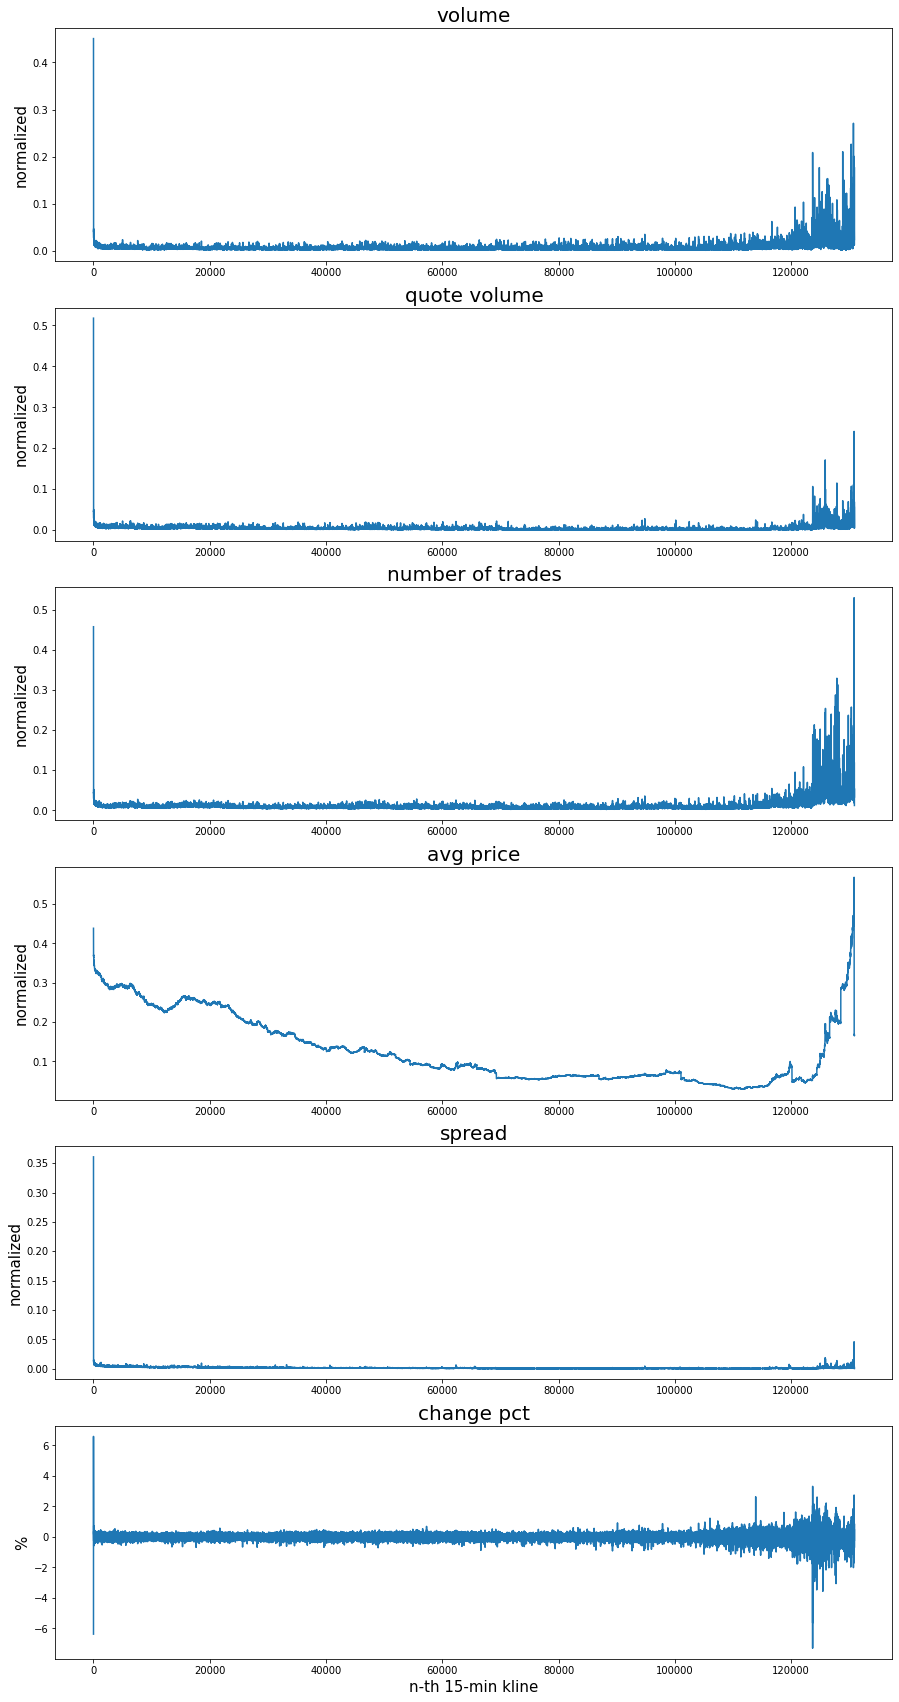

In [5]:
fig, axes = plt.subplots(len(averages_by_age.columns), 1, figsize=(15,30))
for i, col in enumerate(averages_by_age.columns):
    axes[i].plot(averages_by_age.index, averages_by_age[col])
    axes[i].set_title(f"{col.replace('_', ' ')}", size=20)
    axes[i].set_ylabel("normalized", size=15)
axes[-1].set_xlabel("n-th 15-min kline", size=15)
axes[-1].set_ylabel("%", size=15)
plt.show()

In [8]:
%matplotlib widget

print(bnn_data.dropna().head())
corr_mtx = bnn_data.corr(method="kendall").iloc[-3:,8:-3]
fig, ax = plt.subplots(figsize=(30,10)) 
heatmap(corr_mtx, vmin=-1.0, vmax=1.0, annot=True, square=True, ax=ax)
plt.tight_layout()

              ts      open      high       low     close     volume  \
5  1617935400000  0.000001  0.000001  0.000001  0.000001   959821.0   
6  1617936300000  0.000001  0.000001  0.000001  0.000001   969834.0   
7  1617937200000  0.000001  0.000001  0.000001  0.000001   760026.0   
8  1617938100000  0.000001  0.000001  0.000001  0.000001  2346421.0   
9  1617939000000  0.000001  0.000001  0.000001  0.000001  1421560.0   

   quote_volume  number_of_trades        ts_t-1  open_t-1  ...  high_t-5  \
5      1.016218               149  1.617934e+12  0.000001  ...  0.000001   
6      1.028585               213  1.617935e+12  0.000001  ...  0.000001   
7      0.808910               175  1.617936e+12  0.000001  ...  0.000001   
8      2.490444               268  1.617937e+12  0.000001  ...  0.000001   
9      1.495095               112  1.617938e+12  0.000001  ...  0.000001   

    low_t-5  close_t-5  volume_t-5  quote_volume_t-5  number_of_trades_t-5  \
5  0.000001   0.000001   1038480.0    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [4]:
%matplotlib widget

bnn_data["change_pct"] = round(bnn_data["change"] / bnn_data["avg_price"] * 100, 2)
small_changes = bnn_data[bnn_data["change_pct"] <= 0.75]
acceptable_changes = bnn_data[bnn_data["change_pct"] >= 0.75]
fig = plt.figure(figsize=(8,5))
plt.scatter(small_changes.index, small_changes["avg_price"], color="red", s=1.0)
plt.scatter(acceptable_changes.index, acceptable_changes["avg_price"], color="blue", s=1.0)
acceptable_prop = round((acceptable_changes.shape[0] / bnn_data.shape[0] * 100), 2)
small_prop = round((small_changes.shape[0] / bnn_data.shape[0] * 100), 2)
print(f"TOO_SMALL: {small_prop}% || ACCEPTABLE: {acceptable_prop}%")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TOO_SMALL: 75.96% || ACCEPTABLE: 24.05%


In [5]:

acc = []
small = []
for i in range(0,96*30 + 1, 4):
    change = bnn_data["open"] - bnn_data.shift(-i)["close"]
    change_pct = round(change / bnn_data["avg_price"] * 100, 2)
    small_changes = [pct for pct in change_pct if pct <= 0.75]
    acceptable_changes = [pct for pct in change_pct if pct >= 0.75]
    acceptable_prop = round((len(acceptable_changes) / bnn_data.shape[0] * 100), 2)
    small_prop = round((len(small_changes) / bnn_data.shape[0] * 100), 2)
    acc.append((i, acceptable_prop))
    small.append((i, small_prop))

In [9]:
fig2 = plt.figure(figsize=(8,5))
plt.title("% of klines whose change after n 15-min \n periods is above or below comission [ETHBTC]")
plt.plot([a[0] for a in acc], [a[1] for a in acc], color="blue", label="Above comission")
plt.plot([s[0] for s in small], [s[1] for s in small], color="red", label ="Below comission")
from operator import itemgetter
max_shift = max(acc, key=itemgetter(1))[0]
plt.vlines(max_shift, 0, 100)
max_acc = max([a[1] for a in acc])
plt.hlines(max_acc, 0, 3000)
plt.legend()
print(f"Max acceptability {max_acc} at {max_shift} shifts.")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Max acceptability 39.24 at 484 shifts.


In [7]:
plt.close()

In [2]:
for csv in 
bnn_data = pd.read_csv("./data/DOGEBTC.csv", sep=",", names=["ts", "open", "high", "low", "close", "volume", "quote_volume", "number_of_trades"])
columns = bnn_data.columns[:]
for delay in range(1,6):
    for col in columns:
        bnn_data[f"{col}_t-{delay}"] = bnn_data[col].shift(delay)
bnn_data["avg_price"] = (bnn_data["open"] + bnn_data["high"] + bnn_data["low"] + bnn_data["close"]) / 4
bnn_data["change"] = bnn_data["open"] - bnn_data["close"]
bnn_data["spread"] = bnn_data["high"] - bnn_data["low"]